In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import StringType, DoubleType, IntegerType
from shapely.geometry import Point
from pyspark.sql.functions import udf, col, unix_timestamp
from geopy.distance import geodesic
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import DenseVector
from pyspark.ml.clustering import KMeans
from shapely.wkt import loads


In [ ]:
#Inicializa la sesion de Spark
spark = SparkSession.builder \
    .appName("ModeloML") \
    .config("spark.driver.memory", "16g") \
    .getOrCreate()

In [ ]:
def limpiar_NYC_TAXI_ZONES(NYC_TAXI_ZONES):
  """Prepara los datos para ser cargados a un GeoDataframe"""
  # Selecciona las columnas relevantes
  NYC_TAXI_ZONES_limpio = NYC_TAXI_ZONES[['location_id', 'zone', 'borough', 'geometry']]

  # Reproyecta los datos a crs 26918 para que el calculo de los centroides sea adecuado.
  utm_crs = 26918  # Replace with appropriate UTM zone
  NYC_TAXI_ZONES_limpio = NYC_TAXI_ZONES_limpio.to_crs(epsg=utm_crs)

  # Calcula los centroides para cada zona de taxis
  NYC_TAXI_ZONES_limpio['centroid'] = NYC_TAXI_ZONES_limpio.geometry.centroid

  # Transforma los centroides de nuevo a crs 4326
  NYC_TAXI_ZONES_limpio['centroid'] = NYC_TAXI_ZONES_limpio['centroid'].to_crs(epsg=4326)

  # Extrae las coordinadas x y y de los centroides
  NYC_TAXI_ZONES_limpio['centroid_x'] = NYC_TAXI_ZONES_limpio['centroid'].apply(lambda geom: loads(geom.wkt).x)
  NYC_TAXI_ZONES_limpio['centroid_y'] = NYC_TAXI_ZONES_limpio['centroid'].apply(lambda geom: loads(geom.wkt).y)

  # convierte las coordenadas a WKT para garantizar la compatibilidad con PySpark
  NYC_TAXI_ZONES_limpio['geometry'] = NYC_TAXI_ZONES_limpio['geometry'].apply(lambda geom: geom.wkt)
  NYC_TAXI_ZONES_limpio['centroid'] = NYC_TAXI_ZONES_limpio['centroid'].apply(lambda geom: geom.wkt)
  return NYC_TAXI_ZONES_limpio



def limpiar_charging_stations(charging_stations):
    """Prepara los datos para ser cargados a un GeoDataframe"""    
  # Selecciona las columnas relevantes
    charging_stations_limpio = charging_stations.select('Fuel Type Code', 'Station Name', 'Street Address', 'Intersection Directions', 'City', 'State', 'Latitude', 'Longitude')
    
    # Selecciona solamente las estaciones de cargas eléctricas en Nueva York
    charging_stations_limpio = charging_stations_limpio.filter((charging_stations_limpio['City'] == 'New York') & (charging_stations_limpio['Fuel Type Code'] == 'ELEC'))
    
    # Agrega una columna de indice
    charging_stations_limpio = charging_stations_limpio.withColumn("index", monotonically_increasing_id())
    
    # Crea un geoDataFrame
    charging_stations_limpio_pd = charging_stations_limpio.toPandas()
    charging_stations_limpio_gdf = gpd.GeoDataFrame(charging_stations_limpio_pd, geometry=gpd.points_from_xy(charging_stations_limpio_pd['Longitude'], charging_stations_limpio_pd['Latitude']))
    
    # Asigna el CRS a WGS84
    charging_stations_limpio_gdf = charging_stations_limpio_gdf.set_crs(epsg=4326)
    
    # Llena los valores nulos en NaN 'Intersection Directions' con 'No Intersection'
    charging_stations_limpio_gdf['Intersection Directions'] = charging_stations_limpio_gdf['Intersection Directions'].fillna('No Intersection')
    
    # Selecciona las columnas finales
    charging_stations_limpio_gdf = charging_stations_limpio_gdf[['Station Name', 'Street Address', 'Intersection Directions', 'City', 'geometry','Longitude','Latitude']]
    
    charging_stations_limpio_gdf['geometry'] = charging_stations_limpio_gdf['geometry'].apply(lambda x: x.wkt)

    return charging_stations_limpio_gdf

In [ ]:
#Importar y cargar datos
df=spark.read.format("delta").load("dbfs:/mnt/base/Gold/ML/ML_taxis_delta")
Trip_Data = df.sample(withReplacement=False, fraction=0.05, seed=42)
Trip_Data.show(5)

+--------+-------------------+-------------------+-------------+------------+------------+
|VendorID|    pickup_datetime|   dropoff_datetime|trip_distance|PULocationID|DOLocationID|
+--------+-------------------+-------------------+-------------+------------+------------+
|       4|2023-09-01 00:21:13|2023-09-01 00:44:54|         8.97|         231|         140|
|       4|2023-09-01 00:26:11|2023-09-01 00:54:43|         5.51|          48|           7|
|       6|2023-09-01 00:03:31|2023-09-01 00:27:28|       11.222|         119|         252|
|       4|2023-09-01 00:29:09|2023-09-01 01:06:14|        23.05|         108|         171|
|       4|2023-09-01 00:25:56|2023-09-01 01:02:57|         5.08|         186|         265|
+--------+-------------------+-------------------+-------------+------------+------------+
only showing top 5 rows



In [ ]:
df=spark.read.format("delta").load("dbfs:/mnt/base/Gold/ML/ML_taxis_delta")
Trip_Data = df.sample(withReplacement=False, fraction=0.05, seed=42)
Trip_Data.show(5)

+--------+-------------------+-------------------+-------------+------------+------------+
|VendorID|    pickup_datetime|   dropoff_datetime|trip_distance|PULocationID|DOLocationID|
+--------+-------------------+-------------------+-------------+------------+------------+
|       4|2023-09-01 00:21:13|2023-09-01 00:44:54|         8.97|         231|         140|
|       4|2023-09-01 00:26:11|2023-09-01 00:54:43|         5.51|          48|           7|
|       6|2023-09-01 00:03:31|2023-09-01 00:27:28|       11.222|         119|         252|
|       4|2023-09-01 00:29:09|2023-09-01 01:06:14|        23.05|         108|         171|
|       4|2023-09-01 00:25:56|2023-09-01 01:02:57|         5.08|         186|         265|
+--------+-------------------+-------------------+-------------+------------+------------+
only showing top 5 rows



In [ ]:
# List files in the directory to verify the presence of the geojson file
display(dbutils.fs.ls("dbfs:/mnt/base/Bronze/"))

path,name,size,modificationTime
dbfs:/mnt/base/Bronze/Alternative Fuel Vehicles US.csv,Alternative Fuel Vehicles US.csv,123973,1719352281000
dbfs:/mnt/base/Bronze/Complementarios/,Complementarios/,0,1720057810000
dbfs:/mnt/base/Bronze/Electric and Alternative Fuel Charging Stations.csv,Electric and Alternative Fuel Charging Stations.csv,23516042,1719352296000
dbfs:/mnt/base/Bronze/ElectricCarData_Clean.csv,ElectricCarData_Clean.csv,8195,1719352280000
dbfs:/mnt/base/Bronze/ElectricCarData_Norm.csv,ElectricCarData_Norm.csv,13986,1719352280000
dbfs:/mnt/base/Bronze/Light Duty Vehicles.csv,Light Duty Vehicles.csv,571668,1719352281000
dbfs:/mnt/base/Bronze/NYC Taxi Zones.geojson,NYC Taxi Zones.geojson,3892478,1720037585000
dbfs:/mnt/base/Bronze/NYC_TLC/,NYC_TLC/,0,1719583758000
dbfs:/mnt/base/Bronze/Vehicle Fuel Economy Data.csv,Vehicle Fuel Economy Data.csv,14427636,1719352286000
dbfs:/mnt/base/Bronze/data_dictionary_trip_records_yellow.pdf,data_dictionary_trip_records_yellow.pdf,124043,1719352281000


In [ ]:
# Use the /dbfs/ mount point for direct file system access
NYC_TAXI_ZONES_gdf = gpd.read_file('/dbfs/mnt/base/Bronze/NYC Taxi Zones.geojson')
# Clean and process the GeoDataFrame
NYC_TAXI_ZONES_gdf = limpiar_NYC_TAXI_ZONES(NYC_TAXI_ZONES_gdf)
# Convert GeoPandas DataFrame to Pandas DataFrame
NYC_TAXI_ZONES_pdf = pd.DataFrame(NYC_TAXI_ZONES_gdf)
# Convert Pandas DataFrame to PySpark DataFrame
NYC_TAXI_ZONES = spark.createDataFrame(NYC_TAXI_ZONES_pdf)
# Show the first 5 rows
NYC_TAXI_ZONES.show(5)

/root/.ipykernel/925/command-2394329192566947-420157470:21: UserWarning: Geometry column does not contain geometry.
  NYC_TAXI_ZONES_limpio['geometry'] = NYC_TAXI_ZONES_limpio['geometry'].apply(lambda geom: geom.wkt)


+-----------+--------------------+-------------+--------------------+--------------------+------------------+------------------+
|location_id|                zone|      borough|            geometry|            centroid|        centroid_x|        centroid_y|
+-----------+--------------------+-------------+--------------------+--------------------+------------------+------------------+
|          1|      Newark Airport|          EWR|MULTIPOLYGON (((5...|POINT (-74.174001...|-74.17400154655107| 40.69183018869096|
|          2|         Jamaica Bay|       Queens|MULTIPOLYGON (((5...|POINT (-73.831299...| -73.8312994521253| 40.61674623601648|
|          3|Allerton/Pelham G...|        Bronx|MULTIPOLYGON (((5...|POINT (-73.847421...|-73.84742175644048|40.864473719954965|
|          4|       Alphabet City|    Manhattan|MULTIPOLYGON (((5...|POINT (-73.976968...|-73.97696827185617| 40.72375208529322|
|          5|       Arden Heights|Staten Island|MULTIPOLYGON (((5...|POINT (-74.188484...|-74.188

In [ ]:
charging_stations_gdf = spark.read.csv('dbfs:/mnt/base/Bronze/Electric and Alternative Fuel Charging Stations.csv', header=True, inferSchema=True)
# Clean and process the GeoDataFrame
charging_stations_gdf = limpiar_charging_stations(charging_stations_gdf)
# Convert GeoPandas DataFrame to Pandas DataFrame
charging_stations_pdf = pd.DataFrame(charging_stations_gdf)
# Convert Pandas DataFrame to PySpark DataFrame
charging_stations = spark.createDataFrame(charging_stations_pdf)
# Show the first 5 rows
charging_stations.show(5)

+--------------------+---------------+-----------------------+--------+--------------------+----------+---------+
|        Station Name| Street Address|Intersection Directions|    City|            geometry| Longitude| Latitude|
+--------------------+---------------+-----------------------+--------+--------------------+----------+---------+
|Port Authority Bu...|    625 8th Ave|        No Intersection|New York|POINT (-73.990558...|-73.990558|40.756177|
|United Parcel Ser...|  643 W 43rd St|        No Intersection|New York|POINT (-74.000055...|-74.000055|40.762442|
|            Spectrum| 401 W 219th St|        No Intersection|New York|POINT (-73.911616...|-73.911616| 40.87121|
|Central Parking -...|9 W 31st Street|        No Intersection|New York|POINT (-73.986641...|-73.986641|40.747098|
|Environmental Pro...|   290 Broadway|        No Intersection|New York|POINT (-74.005143...|-74.005143|40.714723|
+--------------------+---------------+-----------------------+--------+-----------------

/root/.ipykernel/925/command-2394329192566947-420157470:51: UserWarning: Geometry column does not contain geometry.
  charging_stations_limpio_gdf['geometry'] = charging_stations_limpio_gdf['geometry'].apply(lambda x: x.wkt)


Ingienería de variables

In [ ]:

def agregar_ubicacion_inicio(Trip_Data):
    """
    Hace un join entre Trip_Data y NYC_TAXI_ZONES para tener información geográfica asociada a la salida de cada viaje
    """
    Trip_Data_alias = Trip_Data.alias("trip_data")
    NYC_TAXI_ZONES_alias = NYC_TAXI_ZONES.alias("nyc_zones_start")

    rename_dict = {
        'zone': 'PULzone',
        'borough': 'PULborough',
        'geometry': 'PULgeometry',
        'centroid': 'PULcentroid',
        'Centroid': 'PULCentroid'
    }
    
    # Combina y renombra las nuevas columnas en Trip_Data_alias
    left_join = Trip_Data_alias.join(
        NYC_TAXI_ZONES_alias, col("trip_data.PULocationID") == col("nyc_zones_start.location_id"), 'left'
    ).select(
        *[col("trip_data.*"), 
          *(col(f"nyc_zones_start.{k}").alias(v) for k, v in rename_dict.items()),
          col("nyc_zones_start.centroid_x").alias("PULcentroid_x"),
          col("nyc_zones_start.centroid_y").alias("PULcentroid_y")
         ]
    )

    return left_join

def agregar_ubicacion_final(Trip_Data_Location):
    """
    Hace un join entre Trip_Data y NYC_TAXI_ZONES para tener información geográfica asociada a la llegada de cada viaje
    """
    Trip_Data_Location_alias = Trip_Data_Location.alias("trip_data_location")
    NYC_TAXI_ZONES_alias = NYC_TAXI_ZONES.alias("nyc_zones_end")

    rename_dict = {
        'zone': 'DOLzone',
        'borough': 'DOLborough',
        'geometry': 'DOLgeometry',
        'centroid': 'DOLcentroid',
        'Centroid': 'DOLCentroid'
    }
    
    # Combina y renombra las nuevas columnas en Trip_Data_alias
    left_join = Trip_Data_Location_alias.join(
        NYC_TAXI_ZONES_alias, col("trip_data_location.DOLocationID") == col("nyc_zones_end.location_id"), 'left'
    ).select(
        *[col("trip_data_location.*"), 
          *(col(f"nyc_zones_end.{k}").alias(v) for k, v in rename_dict.items()),
          col("nyc_zones_end.centroid_x").alias("DOLcentroid_x"),
          col("nyc_zones_end.centroid_y").alias("DOLcentroid_y")
         ]
    )

    return left_join

In [ ]:
# Aplica el primer join
Trip_Data_Location = agregar_ubicacion_inicio(Trip_Data)

# Aplica el segundo join
Trip_Data_Location = agregar_ubicacion_final(Trip_Data_Location)

# Muestra las primeras 5 columnas para confirmar
Trip_Data_Location.show(5)

+--------+-------------------+-------------------+-------------+------------+------------+--------------------+----------+--------------------+--------------------+--------------------+------------------+------------------+------------------+----------+--------------------+--------------------+--------------------+------------------+------------------+
|VendorID|    pickup_datetime|   dropoff_datetime|trip_distance|PULocationID|DOLocationID|             PULzone|PULborough|         PULgeometry|         PULcentroid|         PULCentroid|     PULcentroid_x|     PULcentroid_y|           DOLzone|DOLborough|         DOLgeometry|         DOLcentroid|         DOLCentroid|     DOLcentroid_x|     DOLcentroid_y|
+--------+-------------------+-------------------+-------------+------------+------------+--------------------+----------+--------------------+--------------------+--------------------+------------------+------------------+------------------+----------+--------------------+----------------

In [ ]:
# Your UDF and its registration remain the same
def calculate_trip_distance(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Calcula la distancia entre el punto de partida y el punto de llegada
    """
    try:
        pickup_coords = (pickup_lat, pickup_lon)
        dropoff_coords = (dropoff_lat, dropoff_lon)
        distance = geodesic(pickup_coords, dropoff_coords).miles
        return distance
    except Exception as e:
        print(f"Error calculating distance: {e}")
        return None

distance_udf = udf(lambda pickup_lat, pickup_lon, dropoff_lat, dropoff_lon: calculate_trip_distance(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon), DoubleType())

# Ensure the DataFrame name and column names are correct
Trip_Data_Location = Trip_Data_Location.withColumn("calculated_trip_distance", distance_udf(col("PULcentroid_y"), col("PULcentroid_x"), col("DOLcentroid_y"), col("DOLcentroid_x")))

# Use display() for a rich representation of the DataFrame in Databricks
display(Trip_Data_Location.select("VendorID", "pickup_datetime", "dropoff_datetime", "trip_distance", "calculated_trip_distance"))

VendorID,pickup_datetime,dropoff_datetime,trip_distance,calculated_trip_distance
4,2023-09-01T00:21:13,2023-09-01T00:44:54,8.97,4.314737410615054
4,2023-09-01T00:26:11,2023-09-01T00:54:43,5.51,3.6809561150112926
6,2023-09-01T00:03:31,2023-09-01T00:27:28,11.222,6.72984949236432
4,2023-09-01T00:29:09,2023-09-01T01:06:14,23.05,15.352817370257224
4,2023-09-01T00:25:56,2023-09-01T01:02:57,5.08,5385.433835669275
6,2023-09-01T00:47:07,2023-09-01T00:57:26,1.342,1.2488859848311944
4,2023-09-01T01:27:37,2023-09-01T01:37:18,2.02,2.654220077077944
4,2023-09-01T01:14:32,2023-09-01T01:28:59,2.05,1.3485717085901978
4,2023-09-01T01:21:32,2023-09-01T02:03:13,11.37,8.510977976025778
4,2023-09-01T02:25:39,2023-09-01T03:04:18,8.68,5385.595616061024


In [ ]:
def calculate_trip_duration(df):
  """
  Calcula la duración del viaje en minutos
  """
  df = df.withColumn(
      "trip_duration",
      (F.unix_timestamp(F.col("pickup_datetime")) - F.unix_timestamp(F.col("dropoff_datetime"))) / 60.0
  )
  return df
#Se aplica la función a Trip_Data_Location
Trip_Data_Location=calculate_trip_duration(Trip_Data_Location)

Trip_Data_Location.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- PULzone: string (nullable = true)
 |-- PULborough: string (nullable = true)
 |-- PULgeometry: string (nullable = true)
 |-- PULcentroid: string (nullable = true)
 |-- PULCentroid: string (nullable = true)
 |-- PULcentroid_x: double (nullable = true)
 |-- PULcentroid_y: double (nullable = true)
 |-- DOLzone: string (nullable = true)
 |-- DOLborough: string (nullable = true)
 |-- DOLgeometry: string (nullable = true)
 |-- DOLcentroid: string (nullable = true)
 |-- DOLCentroid: string (nullable = true)
 |-- DOLcentroid_x: double (nullable = true)
 |-- DOLcentroid_y: double (nullable = true)
 |-- calculated_trip_distance: double (nullable = true)
 |-- trip_duration: double (nullable = true)



In [ ]:
# Se cargan las coordenadas de las estaciones de carga a una lista de tuplas
charging_stations_coords = charging_stations.select("Latitude", "Longitude").rdd.map(lambda row: (row.Latitude, row.Longitude)).collect()

def calculate_min_distance(lat, lon):
    """
    Calcula la distancia a la estación de carga más cercana
    """
    try:
        centroid_coords = (lat, lon)
        min_distance = float("inf")
        for station_coords in charging_stations_coords:
            distance = geodesic(centroid_coords, station_coords).miles
            if distance < min_distance:
                min_distance = distance
        return min_distance
    except Exception as e:
        print(f"Error calculating distance: {e}")
        return None  # Maneja valores faltantes o geometrías no validas

# Registro UDF
distance_udf = udf(calculate_min_distance, DoubleType())

# Se aplica el registro UDF para encontrar la distancia más cercana
NYC_TAXI_ZONES = NYC_TAXI_ZONES.withColumn("distance_to_nearest_station", distance_udf(col("centroid_y"), col("centroid_x")))

NYC_TAXI_ZONES.select("location_id", "zone", "distance_to_nearest_station").show()

+-----------+--------------------+---------------------------+
|location_id|                zone|distance_to_nearest_station|
+-----------+--------------------+---------------------------+
|          1|      Newark Airport|          8.251155030577053|
|          2|         Jamaica Bay|         10.062204777944054|
|          3|Allerton/Pelham G...|         2.0222196316908727|
|          4|       Alphabet City|         0.5843836771502514|
|          5|       Arden Heights|          5.736437788025277|
|          6|Arrochar/Fort Wad...|         1.3612722077999844|
|          7|             Astoria|         1.4361260790365324|
|          8|        Astoria Park|         0.9440100873714824|
|          9|          Auburndale|          1.598316449994105|
|         24|        Bloomingdale|        0.15311643356796723|
|         10|        Baisley Park|          6.344272231321948|
|         11|          Bath Beach|          4.441194009094442|
|         12|        Battery Park|        0.28762420645

In [ ]:
# Se cargan las coordenadas de las estaciones de carga a una lista de tuplas
charging_stations_coords = charging_stations.select("Latitude", "Longitude").rdd.map(lambda row: (row.Latitude, row.Longitude)).collect()

def count_stations_within_radius(lat, lon, radius=5):
    """
    Count the number of charging stations within the specified radius (in miles) from the centroid.
    """
    try:
        centroid_coords = (lat, lon)
        count = 0
        for station_coords in charging_stations_coords:
            distance = geodesic(centroid_coords, station_coords).miles
            if distance <= radius:
                count += 1
        return count
    except Exception as e:
        print(f"Error calculating count: {e}")
        return None  # Maneja valores faltantes o geometrías no validas

# Registro UDF
count_stations_udf = udf(lambda lat, lon: count_stations_within_radius(lat, lon, radius=5), IntegerType())

# Aplica el UDF para encontrar el numero de estaciones en un ratio de 5 millas
NYC_TAXI_ZONES = NYC_TAXI_ZONES.withColumn("stations_within_5_miles", count_stations_udf(col("centroid_y"), col("centroid_x")))

# Muestra la base de datos resultante
NYC_TAXI_ZONES.select("location_id", "zone", "stations_within_5_miles").show()

+-----------+--------------------+-----------------------+
|location_id|                zone|stations_within_5_miles|
+-----------+--------------------+-----------------------+
|          1|      Newark Airport|                      0|
|          2|         Jamaica Bay|                      0|
|          3|Allerton/Pelham G...|                      5|
|          4|       Alphabet City|                    317|
|          5|       Arden Heights|                      0|
|          6|Arrochar/Fort Wad...|                      1|
|          7|             Astoria|                    304|
|          8|        Astoria Park|                    291|
|          9|          Auburndale|                      3|
|         24|        Bloomingdale|                    284|
|         10|        Baisley Park|                      0|
|         11|          Bath Beach|                      1|
|         12|        Battery Park|                    209|
|         13|   Battery Park City|                    24

In [ ]:
df_location = Trip_Data_Location
df_zones = NYC_TAXI_ZONES

# Se crea un ID que permite identificar cada viaje
df_location = df_location.withColumn("trip_id", monotonically_increasing_id())

# Se unen los dataframes en DOLocationID and location_id
joined_df = df_location.join(df_zones, df_location.DOLocationID == df_zones.location_id, how="left")

# Se seleccionan las columnas deseadas en selected_df
selected_df = joined_df.select("trip_id", "calculated_trip_distance", "trip_duration", "distance_to_nearest_station", "stations_within_5_miles")

# Se muestran los resultados
selected_df.show()

+-------+------------------------+-------------------+---------------------------+-----------------------+
|trip_id|calculated_trip_distance|      trip_duration|distance_to_nearest_station|stations_within_5_miles|
+-------+------------------------+-------------------+---------------------------+-----------------------+
|      0|       4.314737410615054|-23.683333333333334|       0.018068526922607634|                    333|
|      1|      3.6809561150112926|-28.533333333333335|         1.4361260790365324|                    304|
|      2|        6.72984949236432|             -23.95|          2.749559863408384|                      3|
|      3|      15.352817370257224|-37.083333333333336|          2.106317549171043|                      3|
|      4|       5385.433835669275|-37.016666666666666|                       NULL|                   NULL|
|      5|      1.2488859848311944|-10.316666666666666|        0.23222246464629162|                    324|
|      6|       2.654220077077944| -9

In [ ]:
# Define las columnas que van a ser escaladas
input_cols = ['calculated_trip_distance', 'trip_duration', 'distance_to_nearest_station', 'stations_within_5_miles']

# Persist the DataFrame to disk cache
selected_df = selected_df.persist()

# Se define el assembler
assembler = VectorAssembler(inputCols=input_cols, outputCol="features", handleInvalid="skip")

# Se aplica MinMaxScaler para escalar las variables
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Se crea un Pipeline
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(selected_df)
scaled_df = model.transform(selected_df)

# Se extrae cada variable
def extract_element(v, i):
    return float(v[i])

for i, input_col in enumerate(input_cols):
    extract_element_udf = udf(lambda v: extract_element(v, i), FloatType())
    scaled_df = scaled_df.withColumn(input_col + "_scaled", extract_element_udf(scaled_df["scaled_features"]))

# Se seleccionan las columnas deseadas
final_cols = ["trip_id"] + [col + "_scaled" for col in input_cols]
result_df = scaled_df.select(final_cols)

# Se muetran los resultados
result_df.show()

+-------+-------------------------------+--------------------+----------------------------------+------------------------------+
|trip_id|calculated_trip_distance_scaled|trip_duration_scaled|distance_to_nearest_station_scaled|stations_within_5_miles_scaled|
+-------+-------------------------------+--------------------+----------------------------------+------------------------------+
|      0|                    7.998987E-4|           0.9777539|                      8.4172003E-4|                     0.9794118|
|      1|                    6.824035E-4|          0.97641164|                        0.11766171|                    0.89411765|
|      2|                   0.0012476305|           0.9776801|                        0.22586276|                    0.00882353|
|      3|                   0.0028462217|          0.97404546|                        0.17287228|                    0.00882353|
|      5|                   2.3152794E-4|           0.9814531|                       0.018483782|

In [ ]:
from pyspark.sql import functions as F
from pyspark import StorageLevel

# Define los pesos
weights = {
    "calculated_trip_distance": 0.3,
    "trip_duration": 0.1,  
    "distance_to_nearest_station": 0.5,  
    "stations_within_5_miles": 0.1 
}

# Persist the DataFrame to disk cache
result_df = result_df.persist(StorageLevel.DISK_ONLY)

# Se calcula la tasa de necesidad de estaciones de carga para ese viaje
result_df = result_df.withColumn(
    "charging_station_need_score",
    F.col("calculated_trip_distance_scaled") * weights["calculated_trip_distance"] +
    F.col("trip_duration_scaled") * weights["trip_duration"] +
    F.col("distance_to_nearest_station_scaled") * weights["distance_to_nearest_station"] +
    F.col("stations_within_5_miles_scaled") * weights["stations_within_5_miles"]
)

# Se imprimen los resultados
result_df.select("trip_id", "charging_station_need_score").show(truncate=False)


+-------+---------------------------+
|trip_id|charging_station_need_score|
+-------+---------------------------+
|0      |0.1963773954717908         |
|1      |0.24608850400545634        |
|2      |0.21195602901279928        |
|3      |0.18557690258603543        |
|5      |0.20275077947444514        |
|6      |0.3837098667630926         |
|7      |0.14004561896435916        |
|8      |0.3156031534890644         |
|10     |0.26913555550854656        |
|11     |0.17879948988556862        |
|12     |0.3694475316238822         |
|13     |0.14983796591986903        |
|14     |0.2868984939064831         |
|15     |0.21765885489294307        |
|16     |0.44776720221852884        |
|17     |0.20484368146571796        |
|18     |0.447737238323316          |
|19     |0.14927206618012862        |
|20     |0.25149178229039537        |
|21     |0.19864837544737385        |
+-------+---------------------------+
only showing top 20 rows



In [ ]:
from pyspark import StorageLevel

# Se filtra df_location para extraer las coordenadas
df_location_filtered = df_location.select("trip_id", "DOLcentroid_x", "DOLcentroid_y")

# Persist the filtered DataFrame to disk cache
df_location_filtered = df_location_filtered.persist(StorageLevel.DISK_ONLY)
result_df = result_df.persist(StorageLevel.DISK_ONLY)

# Se hace un join
joined_df = df_location_filtered.join(result_df, on="trip_id", how="inner")

# Persist the joined DataFrame to disk cache
joined_df = joined_df.persist(StorageLevel.DISK_ONLY)

# Se seleccionan las columnas que se van a utilizar para entrenar el modelo de ML
final_df = joined_df.select("trip_id", "DOLcentroid_x", "DOLcentroid_y", "charging_station_need_score")

# Se imprime el DataFrame final
final_df.show()


+-------+------------------+------------------+---------------------------+
|trip_id|     DOLcentroid_x|     DOLcentroid_y|charging_station_need_score|
+-------+------------------+------------------+---------------------------+
|     26|-73.99243754291962|40.748497166077094|        0.19995173923671247|
|     29|-73.99815145543047| 40.71245928476423|         0.2796973322983831|
|    474|-73.90235205991539| 40.82751260212183|         0.1495688531547785|
|    964|-73.95101006400093| 40.77876574379631|        0.41813853780331556|
|   1677|              NULL|              NULL|        0.26763553770724685|
|   1697|-73.89895654497252|40.819675684043176|        0.24958029731787973|
|   1806| -73.7896232417029|40.594059182750904|        0.29578736575786024|
|   1950|-73.91682150050266| 40.80734710895816|         0.2578620879678056|
|   2040|-73.95101006400093| 40.77876574379631|         0.1270355713684694|
|   2214|-73.78652969339153| 40.64698504156984|         0.2881602734851186|
|   2250|-73

Modelo de ML

In [ ]:
# Necessary imports
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt

# Initialize Spark session (assuming you have Spark configured)
spark = SparkSession.builder.getOrCreate()

# Importar la función de muestreo aleatorio
from pyspark.sql.functions import rand

# Definir el tamaño de la muestra (porcentaje del total)
sample_size = 0.003  # Ejemplo: usar el 3% de los datos

# Obtener una muestra aleatoria del DataFrame
sampled_df = sampled_df.na.drop(subset=["DOLcentroid_x", "DOLcentroid_y", "charging_station_need_score"])

# Ensamblar las características para la muestra
assembler = VectorAssembler(inputCols=["DOLcentroid_x", "DOLcentroid_y", "charging_station_need_score"], outputCol="features")
sampled_df_kmeans = assembler.transform(sampled_df)

# Definir las coordenadas de las estaciones de carga
charging_stations_coords = charging_stations.select("Latitude", "Longitude").rdd.map(lambda row: (row.Latitude, row.Longitude)).collect()

# Función para calcular la distancia mínima a la estación de carga
def calculate_min_distance(lat, lon):
    try:
        centroid_coords = (lat, lon)
        min_distance = float("inf")
        for station_coords in charging_stations_coords:
            distance = geodesic(centroid_coords, station_coords).miles
            if distance < min_distance:
                min_distance = distance
        return min_distance
    except Exception as e:
        print(f"Error calculating distance: {e}")
        return None

distance_udf = udf(calculate_min_distance, DoubleType())

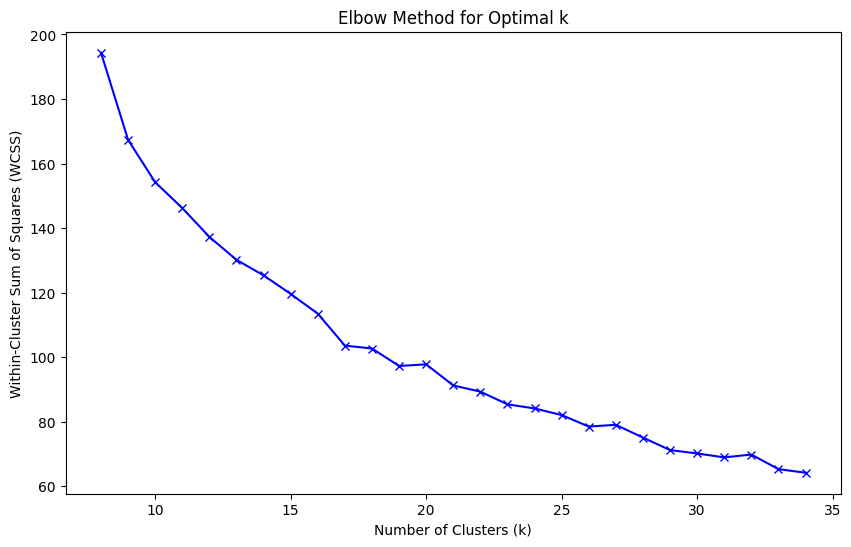

El valor óptimo de k es: 34


In [ ]:
# Optimización de hiperparámetros usando la muestra
def evaluate_kmeans(k):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(sampled_df_kmeans)
    # Calculando el WCSS (Within-Cluster Sum of Squares)
    # Para versiones recientes de PySpark, usar model.summary.trainingCost
    wcss = model.summary.trainingCost
    return wcss

# Definir rango de valores de k para probar
k_values = range(8, 35)
wcss_values = [evaluate_kmeans(k) for k in k_values]

#Realiza el grafico de codos
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss_values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans


# Saca una muestra aleatoria
sample_size = 0.05

sampled_df = final_df.sample(withReplacement=False, fraction=sample_size, seed=1)

assembler = VectorAssembler(
    inputCols=["DOLcentroid_x", "DOLcentroid_y", "charging_station_need_score"],
    outputCol="features",
    handleInvalid="skip"  # Adjust this to handle null values appropriately
)

sampled_df_kmeans = assembler.transform(sampled_df)

# Inicializa el modelo
kmeans = KMeans().setK(19).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(sampled_df_kmeans)

# Entrena el modelo
predictions = model.transform(sampled_df_kmeans)

# Extrae los centroides
centroids = model.clusterCenters()

Preparación para exportar

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, row_number
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
import pyspark.sql.functions as F
from pyspark.sql.window import Window


# Define the schema
schema = StructType([
    StructField("longitude", DoubleType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("Charging station need score", DoubleType(), True)
])

# Convierte los centroides
centroids_list = [(float(row[0]), float(row[1]), float(row[2])) for row in centroids]

# Crea el dataframe
df_points = spark.createDataFrame(centroids_list, schema)

# Organiza el dataset de acuerdo con el indice
df_sorted = df_points.sort("Charging station need score")


total_points = df_sorted.count()
third_size = total_points // 3

# Funcion para asignar los labels
@F.udf("string")
def assign_label_by_order(score_index):
    if score_index <= third_size:
        return "Low"
    elif score_index <= 2 * third_size:
        return "Medium"
    else:
        return "High"

window_spec = Window.orderBy("Charging station need score")
df_with_labels = df_sorted.withColumn("label", assign_label_by_order(row_number().over(window_spec)))

selected_columns = ["longitude", "latitude", "Charging station need score", "label"]
result_df = df_with_labels.select(*selected_columns)

result_df.show()

+------------------+------------------+---------------------------+------+
|         longitude|          latitude|Charging station need score| label|
+------------------+------------------+---------------------------+------+
|-73.97809209445354| 40.74085648900344|          0.140467245627604|   Low|
|-73.88911624964524|40.850423491612354|        0.18843819765917524|   Low|
|-73.95535079107964| 40.78005742614849|        0.19457438318666892|   Low|
|-73.97381753616534| 40.63368804545072|        0.19667588993472748|   Low|
|-73.91623371616608| 40.68132935060531|        0.19681292098960365|   Low|
|-73.98877279519853|40.734683299133565|        0.19756729314479518|   Low|
|  -73.789651958062| 40.71869699758931|        0.20272722916093214|Medium|
|-73.87038242050579| 40.75457789664447|         0.2064795458866275|Medium|
|-73.78895584478201| 40.65184626769596|         0.2093534139765725|Medium|
|-74.14482866677967|40.635842067512876|        0.22254965512656996|Medium|
| -73.9884962032344|40.72

In [ ]:
from pyspark.sql.functions import lit

selected_charging_stations = charging_stations.select('Longitude', 'Latitude').withColumn('label', lit('Ya Existe'))
selected_charging_stations.show()

+----------+---------+---------+
| Longitude| Latitude|    label|
+----------+---------+---------+
|-73.990558|40.756177|Ya Existe|
|-74.000055|40.762442|Ya Existe|
|-73.911616| 40.87121|Ya Existe|
|-73.986641|40.747098|Ya Existe|
|-74.005143|40.714723|Ya Existe|
|-73.997302|40.717522|Ya Existe|
|-73.980414|40.780976|Ya Existe|
|-73.971685|40.753356|Ya Existe|
| -73.95237|40.791232|Ya Existe|
|-73.985704|40.745384|Ya Existe|
|-73.959484|40.782031|Ya Existe|
|-73.993789|40.736754|Ya Existe|
|-73.978966|40.772308|Ya Existe|
|-73.989198|40.734817|Ya Existe|
|-73.989483|40.775704|Ya Existe|
|-73.971353|40.788305|Ya Existe|
|-73.989322|40.736116|Ya Existe|
|-73.996519|40.738352|Ya Existe|
|-73.971145|40.787976|Ya Existe|
|-73.988501|40.775188|Ya Existe|
+----------+---------+---------+
only showing top 20 rows



In [ ]:
df_appended_charging_stations = selected_charging_stations.union(selected_charging_stations)

In [ ]:
from pyspark.sql.functions import col, broadcast
from pyspark.sql import SparkSession


# Extrae una muests
sample_ratio = 0.05  
random_seed = 1  
df_location_sampled = df_location.sample(withReplacement=False, fraction=sample_ratio, seed=random_seed)

# Hace el join
joined_predictions = broadcast(predictions).join(df_location_sampled, predictions["trip_id"] == df_location_sampled["trip_id"], "inner")

# Imprime los resultados
joined_predictions.show()



+-------+------------------+------------------+---------------------------+--------------------+----------+--------+-------------------+-------------------+-------------+------------+------------+--------------------+----------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+----------+--------------------+--------------------+--------------------+------------------+------------------+------------------------+-------------------+-------+
|trip_id|     DOLcentroid_x|     DOLcentroid_y|charging_station_need_score|            features|prediction|VendorID|    pickup_datetime|   dropoff_datetime|trip_distance|PULocationID|DOLocationID|             PULzone|PULborough|         PULgeometry|         PULcentroid|         PULCentroid|     PULcentroid_x|     PULcentroid_y|             DOLzone|DOLborough|         DOLgeometry|         DOLcentroid|         DOLCentroid|     DOLcentroid_x|     DOLcentroid_y|calculated_trip_distan

In [ ]:
joined_predictions = joined_predictions.drop('dolcentroid', 'dolcentroid_x', 'dolcentroid_y', 'pulcentroid','trip_id')
joined_predictions.write.format("delta") \
    .mode('overwrite') \
    .save("dbfs:/mnt/base/Gold/ML/joined_predictions")

In [ ]:
joined_predictions.printSchema()

root
 |-- charging_station_need_score: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)
 |-- VendorID: long (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- PULzone: string (nullable = true)
 |-- PULborough: string (nullable = true)
 |-- PULgeometry: string (nullable = true)
 |-- PULcentroid_x: double (nullable = true)
 |-- PULcentroid_y: double (nullable = true)
 |-- DOLzone: string (nullable = true)
 |-- DOLborough: string (nullable = true)
 |-- DOLgeometry: string (nullable = true)
 |-- calculated_trip_distance: double (nullable = true)
 |-- trip_duration: double (nullable = true)



Exportar los datos

In [ ]:
# Assuming df_appended_charging_stations is your PySpark DataFrame
df_appended_charging_stations.write.format("delta").mode('overwrite').save("dbfs:/mnt/base/Gold/ML/df_appended_charging_stations_delta")

In [ ]:

df=spark.read.format("delta").load("dbfs:/mnt/base/Gold/ML/joined_predictions")
df.show(5)

+---------------------------+--------------------+----------+--------+-------------------+-------------------+-------------+------------+------------+---------------+----------+--------------------+------------------+-----------------+--------------------+----------+--------------------+------------------------+-------------------+
|charging_station_need_score|            features|prediction|VendorID|    pickup_datetime|   dropoff_datetime|trip_distance|PULocationID|DOLocationID|        PULzone|PULborough|         PULgeometry|     PULcentroid_x|    PULcentroid_y|             DOLzone|DOLborough|         DOLgeometry|calculated_trip_distance|      trip_duration|
+---------------------------+--------------------+----------+--------+-------------------+-------------------+-------------+------------+------------+---------------+----------+--------------------+------------------+-----------------+--------------------+----------+--------------------+------------------------+-------------------